<a href="https://colab.research.google.com/github/reitezuz/18NES1-2025-/blob/main/week3/tanh_perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perceptron with continuous activation function and the gradient descent training algorithm

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import time

class Perceptron:
    def __init__(self, input_dim, activation_function='linear', init_method='zero'):
        # weight initialization:
        if init_method == 'random':
            self.weights = np.random.uniform(-1, 1, (input_dim, 1)) / 10  # Random initialization
            self.bias = float(np.random.uniform(-1, 1) / 10)
        elif init_method == 'widrow-hoff':
            self.weights = np.random.randn(input_dim, 1) * (2 / np.sqrt(input_dim))  # Widrow-Hoff rule
            self.bias = float(np.random.randn() * (2 / np.sqrt(input_dim)))
        else: # init_method == 'zero':
            self.weights = np.zeros((input_dim, 1))  # Initialize weights to zeros
            self.bias = 0.0
        self.activation_function = activation_function
        self.epochs = -1

    def set_weights(self, weights, bias):
        self.weights = np.array(weights, dtype=float).reshape(-1, 1)
        self.bias = float(bias)

    def __str__(self):
        return f"Perceptron(weights={self.weights.T}, bias={self.bias})"

    def activation(self, x):
        if self.activation_function == 'linear':
            return x
        elif self.activation_function == 'tanh':
            return np.tanh(x)
        elif self.activation_function == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        else:
            raise ValueError("Unknown activation function")

    def forward(self, inputs):
        potential = np.dot(inputs, self.weights) + self.bias
        #potential = inputs @ self.weights + self.bias
        return self.activation(potential).flatten()

    def gradient_descent_iterative(self, training_inputs, true_outputs, learning_rate=1, epochs=100, adaptive_learning_rate=True, min_error=0, max_validation_steps=None, validation_set = None,  print_progress=False):
        if print_progress:
            print("Gradient Descent iterative:")
        learning_rate_0 = learning_rate # initial learning rate
        training_errors = []
        validation_errors = []

        if validation_set is not None:
            validation_inputs, validation_true_outputs = validation_set
            validation_steps = 0
            previous_validation_error = MSE_error(validation_true_outputs, self.forward(validation_inputs))

        for epoch in range(epochs):

            # Shuffle the training data for each epoch
            shuffled_indices = np.random.permutation(len(training_inputs))
            training_inputs = training_inputs[shuffled_indices]
            true_outputs = true_outputs[shuffled_indices]

            for inputs, true_output in zip(training_inputs, true_outputs):
                prediction = self.forward(inputs) # (1,)
                error = true_output - prediction.reshape(-1, 1) # (1, 1)

                # derivative of the activation function:
                if self.activation_function == 'linear':
                    grad = error  # (1, 1)
                elif self.activation_function == 'tanh':
                    grad = error * (1 - prediction ** 2)  # (1, 1), tanh derivative
                elif self.activation_function == 'sigmoid':
                    grad = error * prediction * (1 - prediction)  # (1, 1), sigmoid derivative
                else:
                    raise ValueError("Unknown activation function")

                self.weights += learning_rate * grad * inputs.reshape(-1, 1)  # (n, 1)
                self.bias += float((learning_rate * error).item())   # Scalar
            if adaptive_learning_rate:
                learning_rate = learning_rate_0 / ((epoch + 1)**0.5)

            # Validation:
            if validation_set:
                validation_mse = MSE_error(validation_true_outputs, self.forward(validation_inputs))
                validation_errors.append(validation_mse)
                if validation_mse < previous_validation_error:
                    validation_steps = 0
                else:
                    validation_steps += 1
                previous_validation_error = validation_mse

            mse = MSE_error(true_outputs, self.forward(training_inputs))
            training_errors.append(mse)
            if print_progress:
                if validation_set:
                    print(f"Epoch: {epoch}, Training MSE: {mse:0.4f}, Validation MSE: {validation_mse:0.4f} Val steps: {validation_steps} Weights: {self.weights.T} Bias: {self.bias} Learning rate: {learning_rate:.4f}")
                else:
                    print(f"Epoch: {epoch}, MSE: {mse:0.4f} Weights: {self.weights.T} Bias: {self.bias} Learning rate: {learning_rate:.4f}")

            # Stop conditions:
            if (mse <= min_error):
                msg = "Minimum error reached."
                break
            elif (max_validation_steps and validation_steps > max_validation_steps):
                msg = "Maximum validation steps reached."
                break
            else:
                msg = "Maximum epochs reached."
        if print_progress:
            print(f"The training ended after {epoch+1} epochs.", msg)
        self.epochs = epoch+1
        return training_errors, validation_errors


    def gradient_descent_batch(self, training_inputs, true_outputs, learning_rate=1, epochs=100, adaptive_learning_rate=True, min_error=0, max_validation_steps=None, validation_set = None,  print_progress=False):
        if print_progress:
            print("Gradient Descent batch:")

        training_inputs = np.array(training_inputs)  # (m, n)
        true_outputs = np.array(true_outputs).reshape(-1, 1)  # (m, 1)
        batch_size = training_inputs.shape[0]  # Scalar

        learning_rate_0 = learning_rate # initial learning rate
        training_errors = []
        validation_errors = []

        if validation_set is not None:
            validation_inputs, validation_true_outputs = validation_set
            validation_steps = 0
            previous_validation_error = MSE_error(validation_true_outputs, self.forward(validation_inputs))

        for epoch in range(epochs):
            prediction = self.forward(training_inputs).reshape(-1, 1)  # (m, 1)
            error = true_outputs - prediction  # (m, 1)

            if self.activation_function == 'linear':
                grad = error  # (m, 1)
            elif self.activation_function == 'tanh':
                grad = error * (1 - prediction ** 2)  # (m, 1), tanh derivative
            elif self.activation_function == 'sigmoid':
                grad = error * prediction * (1 - prediction)  # (m, 1), sigmoid derivative
            else:
                raise ValueError("Unknown activation function")

            weight_gradient = (training_inputs.T @ grad) / batch_size  # (n, 1)
            bias_gradient = np.mean(grad)  # Scalar

            self.weights += learning_rate * weight_gradient  # (n, 1)
            self.bias += learning_rate * bias_gradient  # Scalar


            if adaptive_learning_rate:
                learning_rate = learning_rate_0 / ((epoch + 1)**0.5)

            # Validation:
            if validation_set:
                validation_mse = MSE_error(validation_true_outputs, self.forward(validation_inputs))
                validation_errors.append(validation_mse)
                if validation_mse < previous_validation_error:
                    validation_steps = 0
                else:
                    validation_steps += 1
                previous_validation_error = validation_mse
            mse = MSE_error(true_outputs.flatten(), self.forward(training_inputs))  # (m,)
            training_errors.append(mse)

            if print_progress:
                if validation_set:
                    print(f"Epoch: {epoch}, Training MSE: {mse:0.4f}, Validation MSE: {validation_mse:0.4f} Weights: {self.weights.T} Bias: {self.bias} Learning rate: {learning_rate:.4f}")
                else:
                    print(f"Epoch: {epoch}, MSE: {mse:0.4f} Weights: {self.weights.T} Bias: {self.bias} Learning rate: {learning_rate:.4f}")

            # Stop conditions:
            if (mse <= min_error):
                msg = "Minimum error reached."
                break
            elif (max_validation_steps and validation_steps > max_validation_steps):
                msg = "Maximum validation steps reached."
                break
            else:
                msg = "Maximum epochs reached."
        if print_progress:
            print(f"The training ended after {epoch+1} epochs.", msg)

        self.epochs = epoch + 1
        return training_errors, validation_errors

def sign(x):
    return np.where(x > 0, 1, np.where(x < 0, -1, 0))

def perceptron_error(true_outputs, predicted_outputs):
    return np.sum(true_outputs != np.round(predicted_outputs))

def SSE_error(true_outputs, predicted_outputs):
    # The Sum squared error
    return np.sum((true_outputs - predicted_outputs) ** 2)
def SAE_error(true_outputs, predicted_outputs):
    # The Sum absolute error
    return np.sum(np.abs(true_outputs - predicted_outputs))
def MAE_error(true_outputs, predicted_outputs):
    # The Mean absolute error
    return np.mean(np.abs(true_outputs - predicted_outputs))
def MSE_error(true_outputs, predicted_outputs):
    # The Mean squared error
    return np.mean((true_outputs - predicted_outputs) ** 2)


### Axiliary functions:


In [100]:

def plot_regression_3D(perceptron, training_inputs, true_outputs):
    """Plots the data points and the regression plane in 3D."""

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot of the data points
    ax.scatter(training_inputs[:, 0], training_inputs[:, 1], true_outputs.flatten(),
               label="Data points", color='blue', alpha=0.4, s=50)

    # Create a meshgrid for the plane
    x_range = np.linspace(min(training_inputs[:, 0]), max(training_inputs[:, 0]), 20)
    y_range = np.linspace(min(training_inputs[:, 1]), max(training_inputs[:, 1]), 20)
    X, Y = np.meshgrid(x_range, y_range)

    # Calculate Z values for the plane using the perceptron's weights and bias
    Z = perceptron.weights[0] * X + perceptron.weights[1] * Y + perceptron.bias

    # Plot the regression plane
    ax.plot_surface(X, Y, Z, alpha=0.5, facecolors=plt.cm.Reds(Z), edgecolor='k', rstride=1, cstride=1)

    # Labels
    ax.set_xlabel("x_1")
    ax.set_ylabel("x_2")
    ax.set_zlabel("y")
    ax.set_title("3D Linear Regression Fit")

    plt.show()
def plot_decision_boundary_3D(perceptron, training_inputs, true_outputs):
    """Plots the decision boundary of the perceptron in 3D."""
    # Select first three columns if more than three exist
    training_inputs = training_inputs[:, :3]

    # Check if the input data has 3 features
    if training_inputs.shape[1] != 3:
        raise ValueError("Input data must have at least 3 features for 3D visualization.")

    # Create a meshgrid of points
    x_min, x_max = training_inputs[:, 0].min() - 1, training_inputs[:, 0].max() + 1
    y_min, y_max = training_inputs[:, 1].min() - 1, training_inputs[:, 1].max() + 1
    z_min, z_max = training_inputs[:, 2].min() - 1, training_inputs[:, 2].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                          np.arange(y_min, y_max, 0.1))

    # Calculate z values for the decision boundary
    zz = (-perceptron.weights[0] * xx - perceptron.weights[1] * yy - perceptron.bias) / perceptron.weights[2]

    # Create the 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the decision boundary
    ax.plot_surface(xx, yy, zz, alpha=0.5)

    # Plot the training data points
    ax.scatter(training_inputs[:, 0], training_inputs[:, 1], training_inputs[:, 2], c=true_outputs, cmap=plt.cm.Paired)

    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('x3')
    ax.set_title('Perceptron Decision Boundary (3D)')

    plt.show()
def plot_decision_boundary_2D(perceptron, training_inputs, true_outputs):
    """Plots the decision boundary of the perceptron."""
    import matplotlib.pyplot as plt
    import numpy as np

    # Extract the first two columns of training_inputs
    x1 = training_inputs[:, 0]
    x2 = training_inputs[:, 1]

    # Generate points for visualization
    x_min, x_max = np.min(x1) - 1, np.max(x1) + 1  # Extend the range slightly
    y_min, y_max = np.min(x2) - 1, np.max(x2) + 1  # Extend the range slightly

    x = np.linspace(x_min, x_max, 100)
    weights = perceptron.weights.flatten()
    y = -(weights[0] * x + perceptron.bias) / weights[1]

    plt.figure(figsize=(5, 3))
    # Plot the decision boundary
    plt.plot(x, y, label='Decision Boundary')

    # Plot the points
    for i, input_vector in enumerate(training_inputs):
        if true_outputs[i] == 1:
            plt.scatter(input_vector[0], input_vector[1], color='green', label='Class 1' if i == 0 else "")  # Add label only for the first point of each class
        else:
            plt.scatter(input_vector[0], input_vector[1], color='red', label='Class -1' if i == 0 else "")

    plt.xlabel('x1', fontsize=12)
    plt.ylabel('x2', fontsize=12)
    plt.title('Perceptron Decision Boundary', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)  # Set y-axis limits

    # Highlight x and y axes
    plt.axhline(0, color='black', linewidth=0.8)  # x-axis
    plt.axvline(0, color='black', linewidth=0.8)  # y-axis
    plt.show()

def plot_regression(perceptron, training_inputs, true_outputs):
    """Plots the data points and the regression line."""
    plt.figure(figsize=(4, 3))

    # Plot the data points
    plt.scatter(training_inputs, true_outputs, label="Data points", color='blue', alpha=0.6)

    # Generate predictions for the regression line
    X_test = np.linspace(-1, 1, 100).reshape(-1, 1)
    d_pred = perceptron.weights * X_test + perceptron.bias

    plt.plot(X_test, d_pred, label="Regression line", color='red', linewidth=2)
    plt.xlabel("x_1")
    plt.ylabel("y")
    plt.legend()
    plt.title("Linear Regression Fit")
    plt.show()

def plot_error_progress(train_errors, validation_errors):
    fig = plt.figure(figsize=(4, 3))
    if validation_errors:
        plt.plot(validation_errors, label='Validation Error')
    plt.plot(train_errors, label='Train Error')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.title('Validation and Train Error Progress')
    plt.legend()
    plt.grid(True)
    plt.show()


### Run tests

In [101]:

def run_example_multiple_times(experiment_results, training_data, testing_data, validation_data, activation, epochs, init_method, learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps=10, num_runs=10):
    inputs, true_outputs = training_data
    if testing_data is None:
        testing_data = training_data
    max_validation_steps = None if validation_data is None else max_validation_steps
    test_inputs, test_true_outputs = testing_data
    times = []
    mse_errors = []
    mae_errors = []
    mse_test_errors = []
    mae_test_errors = []
    epoch_counts = []

    for _ in range(num_runs):

        start_time = time.time()
        neuron = Perceptron(inputs.shape[1], activation, init_method)

        if variant == 'iterative':
            neuron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, max_validation_steps, validation_data, print_progress)
        else:
            neuron.gradient_descent_batch(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, print_progress, print_progress=print_progress)

        end_time = time.time()
        elapsed_time = end_time - start_time

        real_outputs = neuron.forward(inputs)
        mse = MSE_error(true_outputs, real_outputs)
        mae = MAE_error(true_outputs, real_outputs)

        real_outputs = neuron.forward(test_inputs)
        mse_test = MSE_error(test_true_outputs, real_outputs)
        mae_test = MAE_error(test_true_outputs, real_outputs)

        times.append(elapsed_time)
        mse_errors.append(mse)
        mae_errors.append(mae)
        mse_test_errors.append(mse_test)
        mae_test_errors.append(mae_test)
        epoch_counts.append(neuron.epochs)

    avg_time = np.mean(times)
    avg_mse = np.mean(mse_errors)
    avg_mae = np.mean(mae_errors)
    avg_test_mse = np.mean(mse_test_errors)
    avg_test_mae = np.mean(mae_test_errors)
    avg_epochs = np.mean(epoch_counts)

    results = {
        'Epochs': avg_epochs,
        'MSE': avg_mse,
        'MAE': avg_mae,
        'Test MSE': avg_test_mse,
        'Test MAE': avg_test_mae,
        'Time': avg_time,
        'Variant': variant,
        'Learning Rate': learning_rate,
        'Max Epochs': epochs,
        'Weights': neuron.weights,  # Note: Weights and bias are from the last run.
        'Bias': neuron.bias,
        'Data Description': data_description
    } #experiment_results_r = pd.DataFrame(columns=['MSE', 'SSE', 'Test MSE' 'Test MAE', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])

    experiment_results.loc[len(experiment_results)] = results

## Example 1:  Gallbladder Attack
- We predict whether a patient will have a gallbladder attack, depending on whether they ate a salad, pork belly, and whether they took medication.

In [102]:
def example_gallblader_attack():
    # Egg Salad, Pork Belly, Medicines -> Gallbladder Attack
    inputs = np.array([
        [+1, -1, -1],
        [+1, -1, +1],
        [-1, +1, -1],
        [-1, +1, +1],
        [+1, +1, -1],
        [+1, +1, +1]
    ])

    true_outputs = np.array([
        +1,
        -1,
        +1,
        -1,
        +1,
        +1
    ])
    return inputs, true_outputs

- Set the parameters, run the experiment and observe the results:
- Compare the results with the Rosenblatt training algorithm (perceptron_examples.ipynb)
- Experiment with the learning rate and other training parameters (maximum number of epochs, adaptive learning rate) and observe, how it affects the training process and the outputs

Gradient Descent iterative:
Epoch: 0, MSE: 0.1500 Weights: [[ 0.52040348  0.55408843 -1.1083196 ]] Bias: 0.1941388845204377 Learning rate: 0.5000
Epoch: 1, MSE: 0.1996 Weights: [[ 0.9443792   0.93977206 -1.69311707]] Bias: -0.2731068952485311 Learning rate: 0.5000
Epoch: 2, MSE: 0.0313 Weights: [[ 1.46544888  1.45945464 -1.19836868]] Bias: 0.31323183180966013 Learning rate: 0.5000
Epoch: 3, MSE: 0.0129 Weights: [[ 1.46772889  1.46537443 -1.35263977]] Bias: 0.16034401246973873 Learning rate: 0.5000
Epoch: 4, MSE: 0.0094 Weights: [[ 1.46885756  1.47115669 -1.42878937]] Bias: 0.10159723429680312 Learning rate: 0.5000
Epoch: 5, MSE: 0.0084 Weights: [[ 1.47624616  1.47874844 -1.47167175]] Bias: 0.11968478996240395 Learning rate: 0.5000
Epoch: 6, MSE: 0.0073 Weights: [[ 1.48068882  1.48595916 -1.51376757]] Bias: 0.10021978080747096 Learning rate: 0.5000
Epoch: 7, MSE: 0.0067 Weights: [[ 1.49103937  1.48966966 -1.54817556]] Bias: 0.08120877734551707 Learning rate: 0.5000
Epoch: 8, MSE: 0.0062

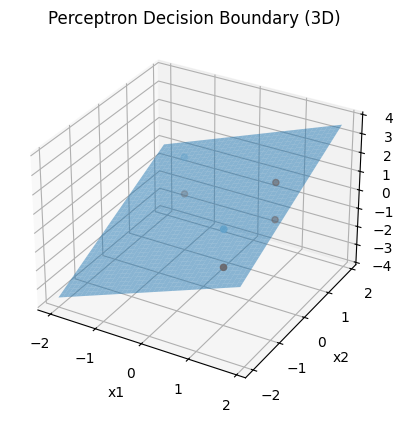

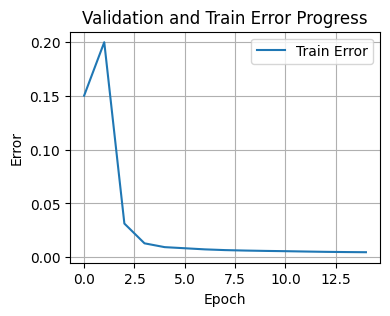

,Input,Predicted,True
0,"[1, -1, -1]",[0.9494417876943183],1
1,"[1, -1, 1]",[-0.9106423277639337],-1
2,"[-1, 1, -1]",[0.9509160512991487],1
3,"[-1, 1, 1]",[-0.9080154545357066],-1
4,"[1, 1, -1]",[0.9998965940635547],1
5,"[1, 1, 1]",[0.9182280637416558],1


In [103]:
# Data and parameters:
inputs, true_outputs = example_gallblader_attack()
data_description = "Gallbladder Attack"

print_progress = True
activation = 'tanh'
learning_rate = 0.5
init_method = 'random'
adaptive_learning_rate = False
min_error = 0.0001
epochs = 15

# Train the linear neuron:
perceptron = Perceptron(inputs.shape[1], activation, init_method)
# perceptron.set_weights(np.array([10000, 10000]), 10000) # set weights to large values
train_errors, val_errors =  perceptron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, print_progress=print_progress)
# Print summary:
print(perceptron)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
error = perceptron_error(true_outputs, real_outputs)
print(f"Perceptron error: {error}")
print(f"MAE error: {MAE_error(true_outputs, real_outputs)}")
print(f"MSE error: {MSE_error(true_outputs, real_outputs)}")
plot_decision_boundary_3D(perceptron, inputs, true_outputs)
plot_error_progress(train_errors, val_errors)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}
df


- finetune parameters of the algorithm:
    1. number of epochs
    2. learning rate
    3. adaptive learning rate or not?

In [104]:
# DataFrame to store the results for comparisons:
experiment_results_r = pd.DataFrame(columns=['MSE', 'MAE', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])

inputs, true_outputs = example_gallblader_attack()
data_description_orig = "Gallbladder Attack"

# Perceptron parameters:
variant = "iterative"
activation = 'tanh'
adaptive_learning_rate = False
min_error = 0.0001
epochs = 100
learning_rate = 0.1
init_method = 'random'
print_progress = False

data_description = data_description_orig + " " + ("adaptive " if adaptive_learning_rate else "non-adaptive ") + str(min_error)

# learning rate:
for learning_rate in [0.01, 0.1 , 1]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), None, None, activation, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps=None)

# epochs:
learning_rate = 0.1
for epochs in [2, 5, 10, 20]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), None, None, activation, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps=None)

# adaptive learning rate:
adaptive_learning_rate = True
data_description = data_description_orig + " " + ("adaptive " if adaptive_learning_rate else "non-adaptive ") + str(min_error)
epochs = 100
for learning_rate in [0.01, 0.1 , 1]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), None, None, activation, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps=None)

print("\nExperiment Results:")
experiment_results_r


Experiment Results:


,MSE,MAE,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,0.097127,0.268318,100.0,0.011719,iterative,0.01,100,"[[0.6592651600798246], [0.6594980379575917], [...",0.243468,Gallbladder Attack non-adaptive 0.0001
1,0.007063,0.072134,100.0,0.012003,iterative,0.10,100,"[[1.4034220270841407], [1.4039947783894102], [...",0.205779,Gallbladder Attack non-adaptive 0.0001
2,0.000184,0.009512,95.7,0.011367,iterative,1.00,100,"[[2.353449421722578], [2.195106958748767], [-2...",0.421430,Gallbladder Attack non-adaptive 0.0001
3,0.313418,0.511516,2.0,0.000687,iterative,0.10,2,"[[0.3196516019926071], [0.33347191269064097], ...",0.141111,Gallbladder Attack non-adaptive 0.0001
4,0.159172,0.349238,5.0,0.001140,iterative,0.10,5,"[[0.491695840339835], [0.486826512554453], [-0...",0.231914,Gallbladder Attack non-adaptive 0.0001
5,0.080726,0.244968,10.0,0.001295,iterative,0.10,10,"[[0.7139719075444025], [0.7154051531989902], [...",0.217100,Gallbladder Attack non-adaptive 0.0001
6,0.038851,0.169084,20.0,0.002657,iterative,0.10,20,"[[0.9363865910309035], [0.9354384813953025], [...",0.227287,Gallbladder Attack non-adaptive 0.0001
7,0.360735,0.557469,100.0,0.012150,iterative,0.01,100,"[[0.18674090364008197], [0.1987249779768245], ...",0.238278,Gallbladder Attack adaptive 0.0001
8,0.044951,0.181227,100.0,0.011575,iterative,0.10,100,"[[0.89668674597286], [0.8968981985326974], [-1...",0.231433,Gallbladder Attack adaptive 0.0001
9,0.001509,0.026129,100.0,0.011333,iterative,1.00,100,"[[2.1816590745206836], [2.5462324661728752], [...",1.037434,Gallbladder Attack adaptive 0.0001


## Example 2:  Pub
- We predict whether the friends (Pavel, Pepa, Honza) will go to a pub depending on who of them has currently time.

In [105]:
def example_pub():
    # Pavel, Pepa, Honza -> Go to a pub?
    inputs = np.array([
        [ +1, -1, -1],
        [ +1, -1, +1],
        [ -1, +1, -1],
        [ -1, +1, +1],
        [ +1, +1, -1],
        [ +1, +1, +1],
        [ -1, -1, -1],
        [ -1, -1, +1]
    ])

    true_outputs = np.array([-1, +1, -1, +1, +1, +1, -1, -1])
    return inputs, true_outputs

- Set the parameters, run the experiment and observe the results:
- Compare the results with the Rosenblatt training algorithm (perceptron_examples.ipynb)
- Experiment with the learning rate and other training parameters (maximum number of epochs, adaptive learning rate) and observe, how it affects the training process and the outputs

Gradient Descent iterative:
Epoch: 0, MSE: 0.6837 Weights: [[1.72575637 0.52017501 0.39734389]] Bias: 0.26482357667827394 Learning rate: 0.5000
Epoch: 1, MSE: 0.0144 Weights: [[1.25060498 1.40024563 1.37276605]] Bias: -0.0933201449877401 Learning rate: 0.5000
Epoch: 2, MSE: 0.0109 Weights: [[1.33386482 1.42322681 1.38822719]] Bias: -0.003126129052692772 Learning rate: 0.5000
Epoch: 3, MSE: 0.0096 Weights: [[1.38529105 1.425659   1.42918933]] Bias: 0.04948229344772492 Learning rate: 0.5000
Epoch: 4, MSE: 0.0086 Weights: [[1.41837855 1.44342614 1.45997567]] Bias: 0.024467164322846513 Learning rate: 0.5000
Epoch: 5, MSE: 0.0078 Weights: [[1.44731415 1.46557467 1.48201646]] Bias: 4.373299730453528e-05 Learning rate: 0.5000
Epoch: 6, MSE: 0.0072 Weights: [[1.47920769 1.49039179 1.49169972]] Bias: -0.037795915240193156 Learning rate: 0.5000
Epoch: 7, MSE: 0.0066 Weights: [[1.50469063 1.50677674 1.51076993]] Bias: -0.01698970228292146 Learning rate: 0.5000
Epoch: 8, MSE: 0.0061 Weights: [[1.5

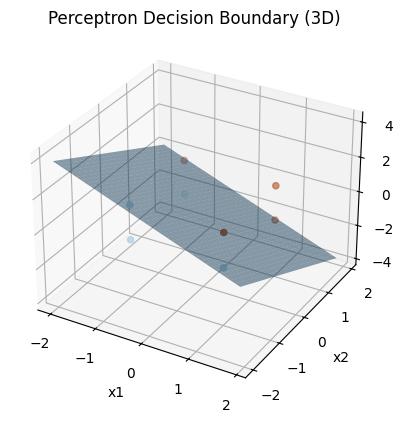

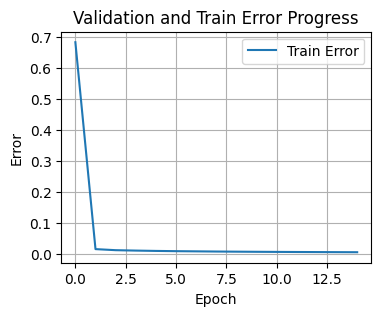

,Input,Predicted,True
0,"[1, -1, -1]",[-0.9247693069329574],-1
1,"[1, -1, 1]",[0.9233096242514001],1
2,"[-1, 1, -1]",[-0.9245776266838878],-1
3,"[-1, 1, 1]",[0.9235043989476057],1
4,"[1, 1, -1]",[0.9229725260587132],1
5,"[1, 1, 1]",[0.9998751514509228],1
6,"[-1, -1, -1]",[-0.9998772964674263],-1
7,"[-1, -1, 1]",[-0.9242458825598492],-1


In [106]:
# Data and parameters:
inputs, true_outputs = example_pub()
data_description = "Pub"

print_progress = True
activation = 'tanh'
learning_rate = 0.5
init_method = 'random'
adaptive_learning_rate = False
min_error = 0.0001
epochs = 15

# Train the linear neuron:
perceptron = Perceptron(inputs.shape[1], activation, init_method)
# perceptron.set_weights(np.array([10000, 10000]), 10000) # set weights to large values
train_errors, val_errors = perceptron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, print_progress=print_progress)
# Print summary:
print(perceptron)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
error = perceptron_error(true_outputs, real_outputs)
print(f"Perceptron error: {error}")
print(f"MAE error: {MAE_error(true_outputs, real_outputs)}")
print(f"MSE error: {MSE_error(true_outputs, real_outputs)}")
plot_decision_boundary_3D(perceptron, inputs, true_outputs)
plot_error_progress(train_errors, val_errors)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}
df


- finetune parameters of the algorithm:
    1. number of epochs
    2. learning rate
    3. adaptive learning rate or not?

In [107]:
# DataFrame to store the results for comparisons:
experiment_results_r = pd.DataFrame(columns=['MSE', 'MAE', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])

inputs, true_outputs = example_gallblader_attack()
data_description_orig = "Gallbladder Attack"

# Perceptron parameters:
variant = "iterative"
activation = 'tanh'
adaptive_learning_rate = False
min_error = 0.0001
epochs = 100
learning_rate = 0.1
init_method = 'random'
print_progress = False

data_description = data_description_orig + " " + ("adaptive " if adaptive_learning_rate else "non-adaptive ") + str(min_error)

# learning rate:
for learning_rate in [0.01, 0.1 , 1]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), None, None, activation, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps=None)

# epochs:
learning_rate = 0.1
for epochs in [2, 5, 10, 20]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), None, None, activation, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps=None)

# adaptive learning rate:
adaptive_learning_rate = True
data_description = data_description_orig + " " + ("adaptive " if adaptive_learning_rate else "non-adaptive ") + str(min_error)
epochs = 100
for learning_rate in [0.01, 0.1 , 1]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), None, None, activation, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps=None)

print("\nExperiment Results:")
experiment_results_r


Experiment Results:


,MSE,MAE,Epochs,Time,Variant,Learning Rate,Max Epochs,Weights,Bias,Data Description
0,0.097980,0.269080,100.0,0.011040,iterative,0.01,100,"[[0.6606926839277855], [0.660452305335011], [-...",0.240411,Gallbladder Attack non-adaptive 0.0001
1,0.007071,0.072175,100.0,0.011042,iterative,0.10,100,"[[1.404448756010033], [1.4037772899030423], [-...",0.209553,Gallbladder Attack non-adaptive 0.0001
2,0.000195,0.010074,82.4,0.009365,iterative,1.00,100,"[[2.236223818416657], [2.3989855666452766], [-...",0.272095,Gallbladder Attack non-adaptive 0.0001
3,0.311067,0.510229,2.0,0.000324,iterative,0.10,2,"[[0.3285543270685121], [0.271959430242405], [-...",0.269481,Gallbladder Attack non-adaptive 0.0001
4,0.156581,0.344624,5.0,0.000609,iterative,0.10,5,"[[0.5365710923663597], [0.5188993646346102], [...",0.259828,Gallbladder Attack non-adaptive 0.0001
5,0.081771,0.246005,10.0,0.001162,iterative,0.10,10,"[[0.7088876053925229], [0.6941742603184715], [...",0.235089,Gallbladder Attack non-adaptive 0.0001
6,0.039047,0.169431,20.0,0.002205,iterative,0.10,20,"[[0.935773993200349], [0.9352388692597662], [-...",0.228942,Gallbladder Attack non-adaptive 0.0001
7,0.357208,0.558053,100.0,0.012314,iterative,0.01,100,"[[0.2646849758679587], [0.2758352727469939], [...",0.154083,Gallbladder Attack adaptive 0.0001
8,0.045212,0.181704,100.0,0.010979,iterative,0.10,100,"[[0.8923768552290339], [0.891986738709978], [-...",0.234740,Gallbladder Attack adaptive 0.0001
9,0.001249,0.025113,100.0,0.010971,iterative,1.00,100,"[[2.0338274970088865], [2.309207359021612], [-...",0.837546,Gallbladder Attack adaptive 0.0001


## Example 3 - Linear regression with two input dimensions
- we normalize the outputs, so that the values are in range [-1, 1]


In [108]:
def generate_regression_data_2D(A=2, B=3, C=-4, std_noise=0.3, number_of_samples=100):
    # y = A x1 + B x2 + C + noise

    # Generate x1 and x2 from a uniform distribution (more variation than linspace)
    x1 = np.random.uniform(-1, 1, number_of_samples).reshape(-1, 1)
    x2 = np.random.uniform(-1, 1, number_of_samples).reshape(-1, 1)
    x2 = x2[np.random.permutation(number_of_samples)]  # Randomly shuffle x2
    inputs = np.hstack([x1, x2])

    # Define true function with noise
    noise = np.random.normal(0, std_noise, size=x1.shape)  # Gaussian noise
    true_outputs = A*x1 + B*x2 + C + noise
    return inputs, normalize_outputs(true_outputs)


def normalize_outputs(outputs):
    min_val = np.min(outputs)
    max_val = np.max(outputs)

    # Normalize to the range [0, 1]
    normalized_outputs = (outputs - min_val) / (max_val - min_val)

    # Scale to the range [-1, 1]
    normalized_outputs = 2 * normalized_outputs - 1

    return normalized_outputs


- observe, that the regression task is very difficult for a perceptron with tanh activation function and that it is very sensitive to the choice of initial learning rate:

Gradient Descent iterative:
Epoch: 0, Training MSE: 0.2490, Validation MSE: 0.2212 Val steps: 1 Weights: [[0.05874043 0.05848256]] Bias: -0.005965285778352498 Learning rate: 0.0002
Epoch: 1, Training MSE: 0.2484, Validation MSE: 0.2213 Val steps: 2 Weights: [[0.06121964 0.06238419]] Bias: -0.008966550434400816 Learning rate: 0.0002
Epoch: 2, Training MSE: 0.2477, Validation MSE: 0.2215 Val steps: 3 Weights: [[0.06368187 0.06625894]] Bias: -0.011906825437949345 Learning rate: 0.0002
Epoch: 3, Training MSE: 0.2472, Validation MSE: 0.2217 Val steps: 4 Weights: [[0.06613022 0.0701044 ]] Bias: -0.014788394312150451 Learning rate: 0.0002
Epoch: 4, Training MSE: 0.2466, Validation MSE: 0.2219 Val steps: 5 Weights: [[0.06856204 0.07392332]] Bias: -0.0176105678080266 Learning rate: 0.0002
Epoch: 5, Training MSE: 0.2461, Validation MSE: 0.2222 Val steps: 6 Weights: [[0.0709776  0.07771606]] Bias: -0.02037620995403163 Learning rate: 0.0002
The training ended after 6 epochs. Maximum validation ste

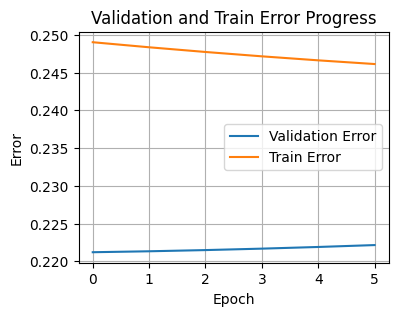

Train Perceptron error: 10000, Test PE: 10000
Train MAE error: 0.4115994111315221, Test MAE: 0.3382329934492127
Train MSE error: 0.24614008137113233, Test MSE: 0.17218672371949925


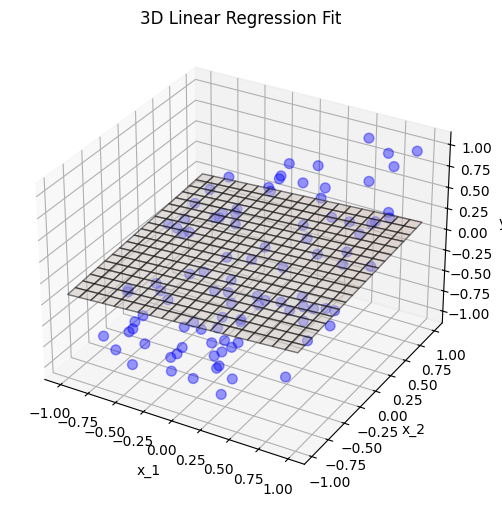

,Input,Predicted,True
0,"[-0.5788941535624104, 0.4866225850512398]",[-0.02364193016699155],[-0.06995058022949674]
1,"[0.49037445716636174, 0.44718650438888274]",[0.049143347615117954],[0.3582125274096013]
2,"[0.8552652815934974, 0.46860255814302954]",[0.07659608803699394],[0.42999805698851956]
3,"[-0.17585344021563865, 0.638982248343074]",[0.016799738535326677],[0.3433360944790764]
4,"[-0.19177323059776796, -0.4744090313381739]",[-0.0707386689399609],[-0.5194312079086192]
...,...,...,...
95,"[-0.9316040869884563, -0.242178392689816]",[-0.10493268557052252],[-0.5880670655048639]
96,"[-0.7224591468128656, -0.09991833927036109]",[-0.07925332574937968],[-0.6210053050223014]
97,"[0.3473875407630935, -0.9687005871551055]",[-0.07088399240304524],[-0.7859904987451954]
98,"[-0.05192051111302809, 0.6145479362316644]",[0.023694406929906705],[0.5407791730046985]


In [109]:
# Define parameters
inputs, true_outputs = generate_regression_data_2D(A=2, B=3, C=-4, std_noise=0.5, number_of_samples=100)
test_inputs, test_true_outputs = generate_regression_data_2D(A=2, B=3, C=-4, std_noise=0.5, number_of_samples=100)
validation_data = generate_regression_data_2D(A=2, B=3, C=-4, std_noise=0.5, number_of_samples=100)

# Train the perceptron:
activation = 'tanh'
print_progress = True
learning_rate = 0.0002
init_method = 'random'
adaptive_learning_rate = False#True #False
min_error = 0.00001
epochs = 100
variant = "iterative" #"batch" #"iterative"
max_validation_steps = 5 #  early stopping

# Train the linear neuron:
perceptron = Perceptron(inputs.shape[1], activation, init_method)
if variant == 'iterative':
    [training_errors, validation_errors] = perceptron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, max_validation_steps, validation_data, print_progress=print_progress)
else:
    [training_errors, validation_errors] = perceptron.gradient_descent_batch(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, max_validation_steps, validation_data, print_progress=print_progress)

# Print summary:
print(perceptron)
plot_error_progress(training_errors, validation_errors)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
test_outputs = perceptron.forward(test_inputs)
print(f"Train Perceptron error: {perceptron_error(true_outputs, real_outputs)}, Test PE: {perceptron_error(test_true_outputs, test_outputs)}")
print(f"Train MAE error: {MAE_error(true_outputs, real_outputs)}, Test MAE: {MAE_error(test_true_outputs, test_outputs)}")
print(f"Train MSE error: {MSE_error(true_outputs, real_outputs)}, Test MSE: {MSE_error(test_true_outputs, test_outputs)}")
plot_regression_3D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}
df

## Example 4:  Randomly Generated Clustered Data


In [110]:
def example_random_clusters(N = 40, spread = 2.0):
    """ Generate two separable clusters """
    cluster_1 = np.random.randn(N//2, 2) * spread + np.array([2, 2])
    cluster_2 = np.random.randn(N//2, 2) * spread + np.array([-2, -2])
    inputs = np.vstack((cluster_1, cluster_2))
    true_outputs = np.hstack((np.ones(N//2), -np.ones(N//2)))  # Labels for clusters
    return inputs, true_outputs.flatten()

- Set the parameters, run the experiment and observe the results:
- Compare the results with the Rosenblatt training algorithm (perceptron_examples.ipynb)
- Experiment with the learning rate and other training parameters (maximum number of epochs, adaptive learning rate) and observe, how it affects the training process and the outputs
- Experiment with biased weights and observe how they affect training

Gradient Descent iterative:
Epoch: 0, Training MSE: 0.8352, Validation MSE: 0.8555 Val steps: 0 Weights: [[ 0.06266852 -0.01446535]] Bias: -0.09082525273095399 Learning rate: 0.0010
Epoch: 1, Training MSE: 0.6022, Validation MSE: 0.5999 Val steps: 0 Weights: [[0.11110168 0.03225752]] Bias: -0.08624653093343629 Learning rate: 0.0007
Epoch: 2, Training MSE: 0.5198, Validation MSE: 0.5126 Val steps: 0 Weights: [[0.1359641  0.05510876]] Bias: -0.08273859704809591 Learning rate: 0.0006
Epoch: 3, Training MSE: 0.4746, Validation MSE: 0.4668 Val steps: 0 Weights: [[0.15309984 0.07000154]] Bias: -0.08006137025884952 Learning rate: 0.0005
Epoch: 4, Training MSE: 0.4452, Validation MSE: 0.4383 Val steps: 0 Weights: [[0.16597094 0.08104429]] Bias: -0.07775040539818953 Learning rate: 0.0004
Epoch: 5, Training MSE: 0.4239, Validation MSE: 0.4184 Val steps: 0 Weights: [[0.17650538 0.08977977]] Bias: -0.0757495809341239 Learning rate: 0.0004
Epoch: 6, Training MSE: 0.4075, Validation MSE: 0.4037 Val 

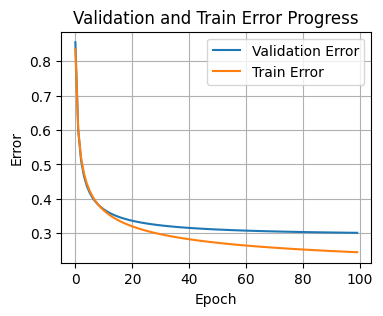

Train Perceptron error: 13, Test PE: 9
Train MAE error: 0.36764289840123054, Test MAE: 0.32364204335633284
Train MSE error: 0.24493296409583767, Test MSE: 0.23362338626494666


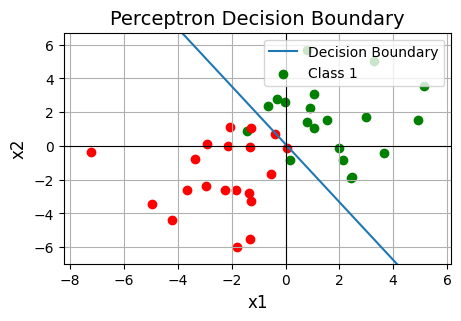

,Input,Predicted,True
0,"[2.9934283060224653, 1.7234713976576308]",[0.8839695837400349],1.0
1,"[3.295377076201385, 5.046059712816051]",[0.9750929226777484],1.0
2,"[1.531693250553328, 1.5317260861016389]",[0.6840810153057033],1.0
3,"[5.158425631014783, 3.534869458305818]",[0.987485690872895],1.0
4,"[1.0610512281300957, 3.085120087171929]",[0.7577712481477545],1.0
5,"[1.0731646143750755, 1.0685404928594862]",[0.5218118106458111],1.0
6,"[2.4839245431320682, -1.8265604893155958]",[0.44644779682087915],1.0
7,"[-1.4498356650260655, 0.8754249415180546]",[-0.3398574806430954],1.0
8,"[-0.02566224066884759, 2.628494665190548]",[0.47156721130591217],1.0
9,"[0.1839518489575782, -0.824607402670583]",[-0.1261192832107023],1.0


In [111]:
# Data and parameters:
np.random.seed(42)
inputs, true_outputs = example_random_clusters()
test_inputs, test_true_outputs = example_random_clusters()
validation_data = example_random_clusters()
data_description = "Clusters"

activation = 'tanh'
print_progress = True
learning_rate = 0.001
init_method = 'random'
adaptive_learning_rate = True #False
min_error = 0.0001
epochs = 100
variant = "iterative" #"batch" #"iterative"
max_validation_steps = 5 #  early stopping

# Train the neuron:
perceptron = Perceptron(inputs.shape[1], activation, init_method)
# perceptron.set_weights(np.array([10000, 10000]), 10000) # set weights to large values
if variant == 'iterative':
    [training_errors, validation_errors] = perceptron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, max_validation_steps, validation_data, print_progress=print_progress)
else:
    [training_errors, validation_errors] = perceptron.gradient_descent_batch(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, max_validation_steps, validation_data, print_progress=print_progress)


# Print summary:
print(perceptron)
plot_error_progress(training_errors, validation_errors)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
test_outputs = perceptron.forward(test_inputs)
print(f"Train Perceptron error: {perceptron_error(true_outputs, real_outputs)}, Test PE: {perceptron_error(test_true_outputs, test_outputs)}")
print(f"Train MAE error: {MAE_error(true_outputs, real_outputs)}, Test MAE: {MAE_error(test_true_outputs, test_outputs)}")
print(f"Train MSE error: {MSE_error(true_outputs, real_outputs)}, Test MSE: {MSE_error(test_true_outputs, test_outputs)}")
plot_decision_boundary_2D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}
df


- observe overfitting for small datsets and try to apply early stopping:
- try both the iterative and batch variant:

Gradient Descent iterative:
Epoch: 0, Training MSE: 0.4830, Validation MSE: 0.7134 Val steps: 1 Weights: [[0.20003342 0.16680533]] Bias: -0.07319801154849757 Learning rate: 0.0100
Epoch: 1, Training MSE: 0.4741, Validation MSE: 0.7471 Val steps: 2 Weights: [[0.23669615 0.19873049]] Bias: -0.08069418235580743 Learning rate: 0.0071
Epoch: 2, Training MSE: 0.4672, Validation MSE: 0.7279 Val steps: 0 Weights: [[0.23679148 0.22048655]] Bias: -0.09259656801524796 Learning rate: 0.0058
Epoch: 3, Training MSE: 0.4643, Validation MSE: 0.7251 Val steps: 0 Weights: [[0.24033987 0.23204336]] Bias: -0.09993375221602238 Learning rate: 0.0050
Epoch: 4, Training MSE: 0.4617, Validation MSE: 0.7125 Val steps: 0 Weights: [[0.23874332 0.24353809]] Bias: -0.10657430241610247 Learning rate: 0.0045
Epoch: 5, Training MSE: 0.4603, Validation MSE: 0.7086 Val steps: 0 Weights: [[0.23986482 0.2511482 ]] Bias: -0.11141195284337559 Learning rate: 0.0041
Epoch: 6, Training MSE: 0.4591, Validation MSE: 0.6985 Val s

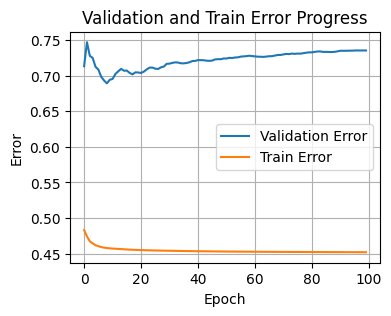

Train Perceptron error: 11, Test PE: 4
Train MAE error: 0.4398020854517034, Test MAE: 0.4021661690941212
Train MSE error: 0.45186271876087036, Test MSE: 0.31606440755828025


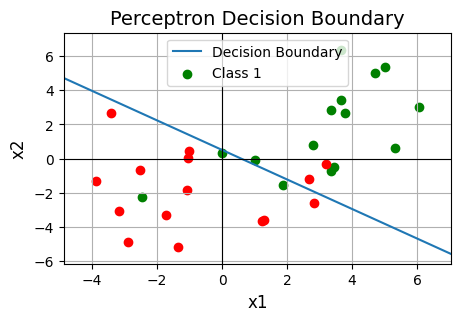

In [112]:
# Data and parameters:
np.random.seed(114570)
inputs, true_outputs = example_random_clusters(N=30, spread=3)
test_inputs, test_true_outputs = example_random_clusters(N=10, spread=3)
validation_data = example_random_clusters(N=10, spread=3)
data_description = "Clusters"

activation = 'tanh'
print_progress = True
learning_rate = 0.01
init_method = 'random'
adaptive_learning_rate = True #False
min_error = 0.0001
epochs = 100
variant = "iterative" #"batch" #"batch" #"iterative"
max_validation_steps = None # 5 #  early stopping

# Train the neuron:
perceptron = Perceptron(inputs.shape[1], activation, init_method)
if variant == 'iterative':
    [training_errors, validation_errors] = perceptron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, max_validation_steps, validation_data, print_progress=print_progress)
else:
    [training_errors, validation_errors] = perceptron.gradient_descent_batch(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, max_validation_steps, validation_data, print_progress=print_progress)


# Print summary:
print(perceptron)
plot_error_progress(training_errors, validation_errors)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
test_outputs = perceptron.forward(test_inputs)
print(f"Train Perceptron error: {perceptron_error(true_outputs, real_outputs)}, Test PE: {perceptron_error(test_true_outputs, test_outputs)}")
print(f"Train MAE error: {MAE_error(true_outputs, real_outputs)}, Test MAE: {MAE_error(test_true_outputs, test_outputs)}")
print(f"Train MSE error: {MSE_error(true_outputs, real_outputs)}, Test MSE: {MSE_error(test_true_outputs, test_outputs)}")
plot_decision_boundary_2D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}
#df

- finetune parameters of the algorithm:
    1. number of epochs
    2. learning rate
    3. adaptive learning rate or not?

In [113]:
# DataFrame to store the results for comparisons:
#experiment_results_r = pd.DataFrame(columns=['MSE', 'MAE', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])
experiment_results_r = pd.DataFrame(columns=['MSE', 'MAE', 'Test MSE', 'Test MAE', 'Epochs', 'Time', 'Variant', 'Learning Rate', 'Max Epochs', 'Weights', 'Bias', 'Data Description'])

np.random.seed(42)  # For reproducibility
inputs, true_outputs = example_random_clusters()
test_inputs, test_true_outputs = example_random_clusters()
validation_data = example_random_clusters()
data_description_orig = "clusters"

# Perceptron parameters:
variant = "iterative"
activation = 'tanh'
adaptive_learning_rate = False
min_error = 0.0001
epochs = 100
learning_rate = 0.1
init_method = 'random'
print_progress = False
max_validation_steps = None

data_description = data_description_orig + " " + ("adaptive " if adaptive_learning_rate else "non-adaptive ") + str(min_error)

for learning_rate in [0.005, 0.01, 0.05, 0.1 , 1]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), (test_inputs, test_outputs), validation_data, activation, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps)
learning_rate = 0.1
for epochs in [1, 2, 5, 10, 20]:
    run_example_multiple_times(experiment_results_r, (inputs, true_outputs), (test_inputs, test_outputs), validation_data, activation, epochs, init_method , learning_rate, print_progress, variant, data_description, adaptive_learning_rate, min_error, max_validation_steps)


print("\nExperiment Results:")
experiment_results_r

ValueError: operands could not be broadcast together with shapes (10,) (40,) 

## Example 4a:  Randomly Generated Clustered Data And Normalization


- the input data are shifted:

In [ ]:
def example_shifted_clusters():
    """ Generate two separable clusters """
    N=40
    spread=2.0
    cluster_1 = np.random.randn(N//2, 2) * spread + np.array([2, 2])+500
    cluster_2 = np.random.randn(N//2, 2) * spread + np.array([-2, -2])+500
    inputs = np.vstack((cluster_1, cluster_2))
    true_outputs = np.hstack((np.ones(N//2), -np.ones(N//2)))  # Labels for clusters
    return inputs, true_outputs

def normalize_data(data):
    """Normalizes data to the range [-1, 1]."""
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)

    # Avoid division by zero if min and max are the same
    max_vals = np.where(max_vals == min_vals, max_vals + 1e-6, max_vals)

    normalized_data = 2 * (data - min_vals) / (max_vals - min_vals) - 1
    return normalized_data

def example_normalized_clusters():
    inputs, true_outputs = example_shifted_clusters()
    return normalize_data(inputs), true_outputs

- Set the parameters, run the experiment and observe the results:
- Observe, that it is very difficult for the perceptron to learn the task, if the input data is not normalized
- Normalize the data and run the experiment again

In [ ]:
def example_random_clusters():
  return example_shifted_clusters()
  # return example_normalized_clusters()

# Data and parameters:
np.random.seed(642)
inputs, true_outputs = example_random_clusters()
test_inputs, test_true_outputs = example_random_clusters()
validation_data = example_random_clusters()
data_description = "Clusters"

activation = 'tanh'
print_progress = True
learning_rate = 0.0005
init_method = 'random'
adaptive_learning_rate = True #False
min_error = 0.0001
epochs = 200
variant = "iterative" #"batch" #"iterative"
max_validation_steps = 5 #  early stopping

# Train the neuron:
perceptron = Perceptron(inputs.shape[1], activation, init_method)
if variant == 'iterative':
    [training_errors, validation_errors] = perceptron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, max_validation_steps, validation_data, print_progress=print_progress)
else:
    [training_errors, validation_errors] = perceptron.gradient_descent_batch(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, max_validation_steps, validation_data, print_progress=print_progress)


# Print summary:
print(perceptron)
plot_error_progress(training_errors, validation_errors)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
test_outputs = perceptron.forward(test_inputs)
print(f"Train Perceptron error: {perceptron_error(true_outputs, real_outputs)}, Test PE: {perceptron_error(test_true_outputs, test_outputs)}")
print(f"Train MAE error: {MAE_error(true_outputs, real_outputs)}, Test MAE: {MAE_error(test_true_outputs, test_outputs)}")
print(f"Train MSE error: {MSE_error(true_outputs, real_outputs)}, Test MSE: {MSE_error(test_true_outputs, test_outputs)}")
plot_decision_boundary_2D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}
df


- normalize the data and run the experiment again:

In [ ]:
def example_random_clusters():
  #return example_shifted_clusters() # comment this row to normalize the data
  return example_normalized_clusters()

# Data and parameters:
np.random.seed(642)
inputs, true_outputs = example_random_clusters()
test_inputs, test_true_outputs = example_random_clusters()
validation_data = example_random_clusters()
data_description = "Clusters"

activation = 'tanh'
print_progress = True
learning_rate = 0.1
init_method = 'random'
adaptive_learning_rate = True #False
min_error = 0.0001
epochs = 200
variant = "iterative" #"batch" #"iterative"
max_validation_steps = 5 #  early stopping

# Train the neuron:
perceptron = Perceptron(inputs.shape[1], activation, init_method)
if variant == 'iterative':
    [training_errors, validation_errors] = perceptron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, max_validation_steps, validation_data, print_progress=print_progress)
else:
    [training_errors, validation_errors] = perceptron.gradient_descent_batch(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, max_validation_steps, validation_data, print_progress=print_progress)


# Print summary:
print(perceptron)
plot_error_progress(training_errors, validation_errors)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
test_outputs = perceptron.forward(test_inputs)
print(f"Train Perceptron error: {perceptron_error(true_outputs, real_outputs)}, Test PE: {perceptron_error(test_true_outputs, test_outputs)}")
print(f"Train MAE error: {MAE_error(true_outputs, real_outputs)}, Test MAE: {MAE_error(test_true_outputs, test_outputs)}")
print(f"Train MSE error: {MSE_error(true_outputs, real_outputs)}, Test MSE: {MSE_error(test_true_outputs, test_outputs)}")
plot_decision_boundary_2D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}
df


## Example 6  - Outliers

In [ ]:
def example_outliers():
    # data with outliers
    inputs = np.array([
        [-0.5, -0.5],
        [ 0.3, -0.5],
        [ -40,   50], # outlier
        [ -0.8, 1],
        [ -0.1, 1.0]
    ])

    true_outputs = np.array([1, 1, -1, -1, 1])
    return inputs, true_outputs

def normalize_data(data):
    """Normalizes data to the range [-1, 1]."""
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)

    # Avoid division by zero if min and max are the same
    max_vals = np.where(max_vals == min_vals, max_vals + 1e-6, max_vals)

    normalized_data = 2 * (data - min_vals) / (max_vals - min_vals) - 1
    return normalized_data

def example_normalized_outliers():
    inputs, true_outputs = example_outliers()
    return normalize_data(inputs), true_outputs

def normalize_data_std(data):
    """Normalizes data using standard deviation."""
    mean_vals = np.mean(data, axis=0)
    std_vals = np.std(data, axis=0)

    # Avoid division by zero if standard deviation is zero
    std_vals = np.where(std_vals == 0, 1e-6, std_vals)  # Add a small value to avoid division by zero

    normalized_data = (data - mean_vals) / std_vals
    return normalized_data

def example_std_normalized_outliers():
    inputs, true_outputs = example_outliers()
    return normalize_data_std(inputs), true_outputs

- Set the parameters, run the experiment and observe the results:
- Observe, that the percepron is able to learn the task

In [ ]:
# Data and parameters:
inputs, true_outputs = example_outliers()
data_description = "Out"

print_progress = True
activation = 'tanh'
learning_rate = 0.8
init_method = 'random'
adaptive_learning_rate = True
min_error = 0.0001
epochs = 20

# Train the linear neuron:
perceptron = Perceptron(inputs.shape[1], activation, init_method)
# perceptron.set_weights(np.array([10000, 10000]), 10000) # set weights to large values
training_errors, validation_errors = perceptron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, print_progress=print_progress)
# Print summary:
print(perceptron)
plot_error_progress(training_errors, validation_errors)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
error = perceptron_error(true_outputs, real_outputs)
print(f"Perceptron error: {error}")
print(f"MAE error: {MAE_error(true_outputs, real_outputs)}")
print(f"MSE error: {MSE_error(true_outputs, real_outputs)}")
plot_decision_boundary_2D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}
df


- Run the same example with normalization
- In this case, blind normalization leads to worse results.

In [ ]:
# Data and parameters:
inputs, true_outputs = example_normalized_outliers()
#inputs, true_outputs = example_std_normalized_outliers()
data_description = "Out"

print_progress = True
activation = 'tanh'
learning_rate = 2
init_method = 'random'
adaptive_learning_rate = True
min_error = 0.0001
epochs = 50

# Train the linear neuron:
perceptron = Perceptron(inputs.shape[1], activation, init_method)
# perceptron.set_weights(np.array([10000, 10000]), 10000) # set weights to large values
perceptron.gradient_descent_iterative(inputs, true_outputs, learning_rate, epochs, adaptive_learning_rate, min_error, print_progress=print_progress)
# Print summary:
print(perceptron)
real_outputs = perceptron.forward(inputs) # forward for the whole dataset
error = perceptron_error(true_outputs, real_outputs)
print(f"Perceptron error: {error}")
print(f"MAE error: {MAE_error(true_outputs, real_outputs)}")
print(f"MSE error: {MSE_error(true_outputs, real_outputs)}")
plot_decision_boundary_2D(perceptron, inputs, true_outputs)

# Create a pandas DataFrame for a nice table
import pandas as pd
df = pd.DataFrame(columns=['Input', 'Predicted', 'True'])
for inputs, label in zip(inputs, true_outputs):
    df.loc[len(df)] = {'Input': inputs, 'Predicted': perceptron.forward(inputs), 'True': label}
df